In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
pd.set_option('display.max_columns', 500)

In [2]:
DF_train = pd.read_csv('CNS_gas_train.csv')
DF_test = pd.read_csv('CNS_gas_test.csv', dtype='object')

In [3]:
X = DF_train.drop(['Country', 'OGA Well Name', 'WH_COORD_SYS', 'WH_SPUD_DATE',
               'WH_COMP_DATE', 'WH_DEPTH_REF', 'WH_WATER_DEPTH_M', 'SAMPLE_ID',
               'SH_SAMPLE_TYPE', 'SH_ORIG_DESC', 'SH_TREATMENT_DESC',
               'SH_LITH', 'SH_AGE', 'SH_AGE_BOT', 'SH_FORM_BOT', 'SH_COMMENT',
               'SAMPLE_ID_GM', 'SAMPLE_ID_SAM', 'EXT_SAMPLE_VENDOR', 'SAMPLE_ID_EXT', 
               'GAS_TOTAL_CONCENTRATION', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'C3_UNSAT', 'GAS_IC4', 
               'GAS_NC4', 'C4_UNSAT', 'GAS_IC5', 'GAS_NC5', 'C5_UNSAT', 'GAS_NC5_PLUS', 
               'GAS_H2S', 'GAS_HE', 'D_G_DATA_TYPE', 'CSIA_NEOC5', 'DS_G_H2S', 
               'DD_G_H2', 'DO_G_CO2', 'DN_G_N2', 'DD_G_GAS', 'DD_G_NC1', 'DD_G_NC2',
               'DD_G_NC3', 'DD_G_IC4', 'DD_G_NC4', 'DD_G_IC5', 'DD_G_NC5',
               'SH_CDATE', 'GAS_ACQ_DATE', 'D_G_ACQ_DATE', 
               'WELL_NAME', 'WH_SITETYPE', 'WH_FIELD', 'WH_BLOCK', 'SH_FORM'], axis=1)
Y =  DF_train[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
X = X.drop(0)
Y = Y.drop(0)
for col in X.columns:
    X[col] = X[col].str.upper()

In [4]:
Xt = DF_test.drop(['Country', 'OGA Well Name', 'WH_COORD_SYS', 'WH_SPUD_DATE',
               'WH_COMP_DATE', 'WH_DEPTH_REF', 'WH_WATER_DEPTH_M', 'SAMPLE_ID',
               'SH_SAMPLE_TYPE', 'SH_ORIG_DESC', 'SH_TREATMENT_DESC',
               'SH_LITH', 'SH_AGE', 'SH_AGE_BOT', 'SH_FORM_BOT', 'SH_COMMENT',
               'SAMPLE_ID_GM', 'SAMPLE_ID_SAM', 'EXT_SAMPLE_VENDOR', 'SAMPLE_ID_EXT', 
               'GAS_TOTAL_CONCENTRATION', 'GAS_C1', 'GAS_C2', 'GAS_C3', 'C3_UNSAT', 'GAS_IC4', 
               'GAS_NC4', 'C4_UNSAT', 'GAS_IC5', 'GAS_NC5', 'C5_UNSAT', 'GAS_NC5_PLUS', 
               'GAS_H2S', 'GAS_HE', 'D_G_DATA_TYPE', 'CSIA_NEOC5', 'DS_G_H2S', 
               'DD_G_H2', 'DO_G_CO2', 'DN_G_N2', 'DD_G_GAS', 'DD_G_NC1', 'DD_G_NC2',
               'DD_G_NC3', 'DD_G_IC4', 'DD_G_NC4', 'DD_G_IC5', 'DD_G_NC5',
               'SH_CDATE', 'GAS_ACQ_DATE', 'D_G_ACQ_DATE', 
               'WELL_NAME', 'WH_SITETYPE', 'WH_FIELD', 'WH_BLOCK', 'SH_FORM'], axis=1)
Yt =  DF_test[['GAS_C1', 'GAS_C2', 'GAS_C3', 'GAS_IC4', 'GAS_NC4', 'GAS_IC5', 'GAS_NC5']]
for col in Xt.columns:
    Xt[col] = Xt[col].str.upper()

In [5]:
NOT_CAT = X.drop(['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE', 'D_G_METHOD',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_LAB'], axis=1)
CAT = X[['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_METHOD', 'D_G_LAB']]
CAT = CAT.replace(np.nan, 'XXXXX')
enc = OneHotEncoder()
enc.fit(CAT)
onehotlab = pd.DataFrame(enc.transform(CAT).toarray())
NOT_CAT = NOT_CAT.reset_index(drop=True)
X_NEW = pd.concat([NOT_CAT, onehotlab], axis=1)
X_NEW = X_NEW.replace('WORLD GEODETIC SYSTEM 1984', '0.0')
X_NEW = np.array(X_NEW, dtype='float64')
X_NEW.shape

In [6]:
NOT_CATt = Xt.drop(['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE', 'D_G_METHOD',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_LAB'], axis=1)
CATt = Xt[['WH_OPERATOR', 'SH_SAMPLE_SUB_TYPE',
         'SH_ORIG', 'SH_TREATMENT', 'GAS_METHOD', 'GAS_LAB', 'D_G_METHOD', 'D_G_LAB']]
CATt['WH_OPERATOR'].fillna('SHELL', inplace=True)
CATt = CATt.replace(np.nan, 'XXXXX')
onehotlabt = pd.DataFrame(enc.transform(CATt).toarray())
NOT_CATt = NOT_CATt.reset_index(drop=True)
Xt_NEW = pd.concat([NOT_CATt, onehotlabt], axis=1)
Xt_NEW = np.array(Xt_NEW)
Xt_NEW.shape

C:\Users\mserg\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(100, 86)

In [8]:
Y1 = Y[['GAS_C1']]
Y1 = np.array(Y1, dtype='float64')
Y2 = Y[['GAS_C2']]
Y2 = np.array(Y2, dtype='float64')
Y3 = Y[['GAS_C3']]
Y3 = np.array(Y3, dtype='float64')
Y4 = Y[['GAS_IC4']]
Y4 = np.array(Y4, dtype='float64')
Y5 = Y[['GAS_NC4']]
Y5 = np.array(Y5, dtype='float64')
Y6 = Y[['GAS_IC5']]
Y6 = np.array(Y6, dtype='float64')
Y7 = Y[['GAS_NC5']]
Y7 = np.array(Y7, dtype='float64')

In [9]:
print(X_NEW.shape)
print(Y.shape)

(1709, 86)
(1709, 7)


In [10]:
dtrain1 = xgb.DMatrix(X_NEW, Y1)
dtest1 = xgb.DMatrix(Xt_NEW)
dtrain2 = xgb.DMatrix(X_NEW, Y2)
dtest2 = xgb.DMatrix(Xt_NEW)
dtrain3 = xgb.DMatrix(X_NEW, np.log(Y3+0.001))
dtest3 = xgb.DMatrix(Xt_NEW)
dtrain4 = xgb.DMatrix(X_NEW, np.log(Y4+0.001))
dtest4 = xgb.DMatrix(Xt_NEW)
dtrain5 = xgb.DMatrix(X_NEW, np.log(Y5+0.001))
dtest5 = xgb.DMatrix(Xt_NEW)
dtrain6 = xgb.DMatrix(X_NEW, np.log(Y6+0.001))
dtest6 = xgb.DMatrix(Xt_NEW)
dtrain7 = xgb.DMatrix(X_NEW, np.log(Y7+0.0001))
dtest7 = xgb.DMatrix(Xt_NEW)

In [11]:
param1 = {'max_depth':6, 'eta':0.04, 'reg_alpha': 1.0, 'gamma': 0.01, 'reg_lambda': 1.5, 'silent':1}
param2 = {'eta': 0.04, 'gamma': 0.01, 'max_depth': 6, 'reg_alpha': 1.0, 'reg_lambda': 2.0, 'silent':1}
param3 = {'eta': 0.04, 'gamma': 0.01, 'max_depth': 7, 'reg_alpha': 1.0, 'reg_lambda': 2.5, 'silent':1}
param4 = {'eta': 0.045, 'gamma': 0.01, 'max_depth': 6, 'reg_alpha': 2.0, 'reg_lambda': 0.5, 'silent':1}
param5 = {'max_depth':6, 'eta':0.05, 'reg_alpha': 1.0, 'gamma': 0.01, 'reg_lambda': 1.0, 'silent':1}
param6 = {'eta': 0.05, 'gamma': 0.01, 'max_depth': 6, 'silent':1}
param7 = {'max_depth':6, 'eta':0.05, 'reg_alpha': 1.0, 'gamma': 0.01, 'reg_lambda': 2.5, 'silent':1}
num_round = 1000

In [12]:
boost1 = xgb.train(param1, dtrain1, num_round)
boost2 = xgb.train(param2, dtrain2, num_round)
boost3 = xgb.train(param3, dtrain3, num_round)
boost4 = xgb.train(param4, dtrain4, num_round)
boost5 = xgb.train(param5, dtrain5, num_round)
boost6 = xgb.train(param6, dtrain6, num_round)
boost7 = xgb.train(param7, dtrain7, num_round)

In [47]:
y_pred1 = boost1.predict(dtest1)
y_pred2 = boost2.predict(dtest2)
y_pred3 = np.exp(boost3.predict(dtest3))-0.001
y_pred4 = np.exp(boost4.predict(dtest4))-0.001
y_pred5 = np.exp(boost5.predict(dtest5))-0.001
y_pred6 = np.exp(boost6.predict(dtest6))-0.001
y_pred7 = np.exp(boost7.predict(dtest7))-0.0001

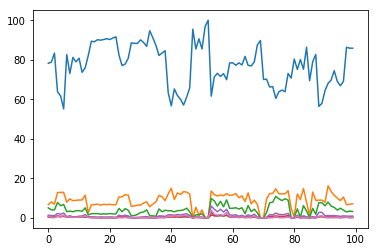

In [58]:
plt.plot(y_pred1)
plt.plot(y_pred2)
plt.plot(y_pred3)
plt.plot(y_pred4)
plt.plot(y_pred5)
plt.plot(y_pred6)
plt.plot(y_pred7)

In [55]:
predictions = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6, y_pred7]
for pr in predictions:
    for i, el in enumerate(pr):
        if el > 100:
            pr[i] = 100
        if el < 0:
            pr[i] = 0

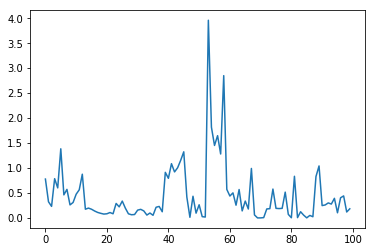

In [76]:
plt.plot(y_pred7)

In [66]:
DF_test.head(3)

,Country,WELL_NAME,OGA Well Name,WH_SITETYPE,WH_FIELD,WH_BLOCK,WH_LAT,WH_LONG,WH_COORD_SYS,WH_OPERATOR,WH_SPUD_DATE,WH_SPUD_YEAR,WH_COMP_DATE,WH_TD_M,WH_DR_ELEV_M,WH_DEPTH_REF,WH_WATER_DEPTH_M,SAMPLE_ID,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SH_SAMPLE_TYPE,SH_SAMPLE_SUB_TYPE,SH_ORIG,SH_ORIG_DESC,SH_TREATMENT,SH_TREATMENT_DESC,SH_LITH,SH_AGE,SH_AGE_BOT,SH_FORM,SH_FORM_BOT,SH_CDATE,SH_COMMENT,SAMPLE_ID_GM,SAMPLE_ID_GDB,SAMPLE_ID_SAM,EXT_SAMPLE_VENDOR,SAMPLE_ID_EXT,GAS_METHOD,GAS_LAB,GAS_ACQ_DATE,GAS_TOTAL_CONCENTRATION,GAS_AIR,GAS_C1,GAS_C2,C2_UNSAT,GAS_C3,C3_UNSAT,GAS_IC4,GAS_NC4,C4_UNSAT,GAS_NEOC5,GAS_IC5,GAS_NC5,C5_UNSAT,GAS_NC5_PLUS,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_H2S,GAS_HE,GAS_N2,D_G_METHOD,D_G_LAB,D_G_DATA_TYPE,D_G_ACQ_DATE,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_NEOC5,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2,DO_G_CO2,DS_G_H2S,DD_G_H2,DN_G_N2,DD_G_GAS,DD_G_NC1,DD_G_NC2,DD_G_NC3,DD_G_IC4,DD_G_NC4,DD_G_IC5,DD_G_NC5
0,United Kingdom,021/30-13A,21/30- 13A,WELL,NaN,021/30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXPRO_5918,7375.98,7425.98,Gas,Unspecified,NaN,NaN,ASIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000132,NaN,NaN,NaN,UNKNOWN,RTS,01-01-00 0:00,NaN,NaN,78.233368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.49,NaN,0.59,NaN,NaN,NaN,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United Kingdom,021/30-13A,21/30- 13A,WELL,NaN,021/30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPC_317898,7376,7386,Gas,Unspecified,NaN,NaN,ASIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"GMC 0383, Bottle no. A 17581; Forties Sands Zo...",NaN,143560,NaN,NaN,NaN,Air corrected,KSEPL,7/14/2006 0:00,NaN,NaN,78.822456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35,0,0.91,NaN,NaN,NaN,0.94,GCMS,KSEPL,NaN,NaN,NaN,-56.3,-39.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United Kingdom,021/30-13A,21/30- 13A,WELL,NaN,021/30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPC_317900,7376,7426,Gas,Unspecified,NaN,NaN,ASIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"GMC 0385, Bottle no. A 17636; Forties Sands Zo...",NaN,143561,NaN,NaN,NaN,Air corrected,KSEPL,7/14/2006 0:00,NaN,NaN,83.368202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.32,NaN,0.83,NaN,NaN,NaN,1.12,GCMS,KSEPL,NaN,NaN,NaN,-56.3,-39.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
DF_test.loc[:, 'GAS_C1'] = y_pred1
DF_test.loc[:, 'GAS_C2'] = y_pred2
DF_test.loc[:, 'GAS_C3'] = y_pred3
DF_test.loc[:, 'GAS_IC4'] = y_pred4
DF_test.loc[:, 'GAS_NC4'] = y_pred5
DF_test.loc[:, 'GAS_IC5'] = y_pred6
DF_test.loc[:, 'GAS_NC5'] = y_pred7

In [68]:
DF_test.head(3)

,Country,WELL_NAME,OGA Well Name,WH_SITETYPE,WH_FIELD,WH_BLOCK,WH_LAT,WH_LONG,WH_COORD_SYS,WH_OPERATOR,WH_SPUD_DATE,WH_SPUD_YEAR,WH_COMP_DATE,WH_TD_M,WH_DR_ELEV_M,WH_DEPTH_REF,WH_WATER_DEPTH_M,SAMPLE_ID,SH_DEPTH_TOP_FT,SH_DEPTH_BOT_FT,SH_SAMPLE_TYPE,SH_SAMPLE_SUB_TYPE,SH_ORIG,SH_ORIG_DESC,SH_TREATMENT,SH_TREATMENT_DESC,SH_LITH,SH_AGE,SH_AGE_BOT,SH_FORM,SH_FORM_BOT,SH_CDATE,SH_COMMENT,SAMPLE_ID_GM,SAMPLE_ID_GDB,SAMPLE_ID_SAM,EXT_SAMPLE_VENDOR,SAMPLE_ID_EXT,GAS_METHOD,GAS_LAB,GAS_ACQ_DATE,GAS_TOTAL_CONCENTRATION,GAS_AIR,GAS_C1,GAS_C2,C2_UNSAT,GAS_C3,C3_UNSAT,GAS_IC4,GAS_NC4,C4_UNSAT,GAS_NEOC5,GAS_IC5,GAS_NC5,C5_UNSAT,GAS_NC5_PLUS,GAS_C6PLUS,GAS_O2,GAS_CO2,GAS_H2,GAS_H2S,GAS_HE,GAS_N2,D_G_METHOD,D_G_LAB,D_G_DATA_TYPE,D_G_ACQ_DATE,CSIA_CONC_C1,CSIA_NC1,CSIA_NC2,CSIA_NC3,CSIA_IC4,CSIA_NC4,CSIA_NEOC5,CSIA_IC5,CSIA_NC5,CSIA_ETHENE,CSIA_PROPENE,DC_G_CO2,DO_G_CO2,DS_G_H2S,DD_G_H2,DN_G_N2,DD_G_GAS,DD_G_NC1,DD_G_NC2,DD_G_NC3,DD_G_IC4,DD_G_NC4,DD_G_IC5,DD_G_NC5
0,United Kingdom,021/30-13A,21/30- 13A,WELL,NaN,021/30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,EXPRO_5918,7375.98,7425.98,Gas,Unspecified,NaN,NaN,ASIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000132,NaN,NaN,NaN,UNKNOWN,RTS,01-01-00 0:00,NaN,NaN,78.233368,6.751720,NaN,5.090632,NaN,0.752013,1.381126,NaN,NaN,0.402910,0.778356,NaN,NaN,1.49,NaN,0.59,NaN,NaN,NaN,0.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,United Kingdom,021/30-13A,21/30- 13A,WELL,NaN,021/30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPC_317898,7376,7386,Gas,Unspecified,NaN,NaN,ASIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"GMC 0383, Bottle no. A 17581; Forties Sands Zo...",NaN,143560,NaN,NaN,NaN,Air corrected,KSEPL,7/14/2006 0:00,NaN,NaN,78.822456,8.059817,NaN,4.054619,NaN,0.528433,1.185236,NaN,NaN,0.209306,0.323846,NaN,NaN,0.35,0,0.91,NaN,NaN,NaN,0.94,GCMS,KSEPL,NaN,NaN,NaN,-56.3,-39.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,United Kingdom,021/30-13A,21/30- 13A,WELL,NaN,021/30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FPC_317900,7376,7426,Gas,Unspecified,NaN,NaN,ASIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"GMC 0385, Bottle no. A 17636; Forties Sands Zo...",NaN,143561,NaN,NaN,NaN,Air corrected,KSEPL,7/14/2006 0:00,NaN,NaN,83.368202,6.990275,NaN,4.054619,NaN,0.530307,1.186545,NaN,NaN,0.190703,0.231673,NaN,NaN,0.32,NaN,0.83,NaN,NaN,NaN,1.12,GCMS,KSEPL,NaN,NaN,NaN,-56.3,-39.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
DF_test.to_csv('SUBMIT.csv', index=False)

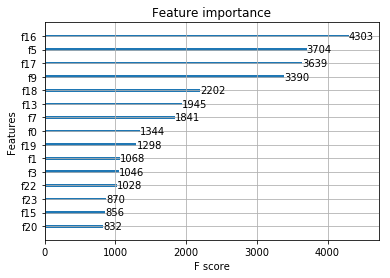

In [105]:
xgb.plot_importance(boost2, max_num_features=15)
plt.savefig('f_imp.jpg')